## <b>Stat 306 Group Project </b> 
<b> Group Members</b> Malachy montemurro (39614227), Xinzi Wang (18557694), Yue Yu(68900406), Jiawei Huang(72611429)



<b>Introduction</b>
<br>
<b>Motivation</b> <br>
With the rapid development of the Internet and the rise in people's demand for relaxation, online videos on the Internet have taken up an important part of people's daily entertainment life (Bärtl, 2018). In this project, we want to find useful insights into the development of the online video.<br><br>
In this paper, we choose YouTube channels as the object of study. We will be answering the research question: how does the total number of views of a channel relate to the year the channel is created, the number of subscribers it has, the number of videos uploaded, and the category of the channel. Our objective was to find a linear model between the total number of views of the channel and the four explanatory variables. We assume that it is negatively correlated with the year, positively correlated with the number of subscribers, and positively correlated with the number of videos uploaded. <br>

<b>Data Collection</b> <br>
Kaggle is an online community platform for data scientists and machine learning enthusiasts, it provides free and open access to global development data. For this research, we chose the database Most Subscribed YouTube Channels (Jha, 2022), as the resource and our four variables are retrieved from Kaggle by selecting the corresponding indicators. From the database, we selected the channels that fall into these four categories: People & Blogs, Entertainment, Music, and Gaming for this research.   Furthermore, the data set contained two additional columns, name of the channel, and rank of the channel (by the number of subscribers). We decided to exclude the rank of the channels, because we deemed it redundant, as it is analogous with the subscribers variable, and may cause a singularity in the design matrix. Specific descriptions of the variables are as follows: <br>

<b>Response Variable</b> <br>
Video views: Total video views of a channel. <br> 
Unit: count <br>
<b> Explanatory Variables</b> <br>
Subscribers: Number of subscribers one channel has.<br>
Unit: Person
<br> 
Video count: Number of videos a channel has been uploaded thus far. <br>
Unit: Videos
<br> 
Started: Year the channel was started
<br> 
Unit: Years <br>
<b>Explanatory Categorical Variable:</b> <br>
Category: one of “People & Blogs”, “Entertainment”, “Music”, and “Gaming”. <br>
Baseline: Entertainment



mention in conclusion: limitation - top ranking channels, not average channel 
- top ranking channels (not representative of population), so if we randomly sampled x channels, our model will not fit the data well. 

<b>Data Pre-Processing and Cleaning </b>

In [1]:
library(tidyverse)
library(leaps)
library(broom)
library(repr)
library(digest)
library(faraway)
library(mltools)
library(glmnet)
library(cowplot)
library(readxl)
library(GGally)
library(infer)
library(rsample)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:faraway’:

    happy




In [2]:
data1<-read.csv("most_subscribed.csv")
head(data1, 3)

,rank,Youtuber,subscribers,video.views,video.count,category,started
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,T-Series,"222,000,000","198,459,090,822","17,317",Music,2006
2,2,YouTube Movies,"154,000,000",0,0,Film & Animation,2015
3,3,Cocomelon - Nursery Rhymes,"140,000,000","135,481,339,848",786,Education,2006


In [3]:
#Cleaning Data: 
row_sub = apply(data1, 1, function(row) all(row !=0 ))
data1 <- data1[row_sub,]
data <- data1[data1$category %in% c("Gaming", "Music", "Entertainment", "People & Blogs"),]

In [6]:
#Cleaning Data
data$subscribers<- as.numeric(gsub(",","",data$subscribers))
data$video.views<- as.numeric(gsub(",","",data$video.views))
data$video.count<- as.numeric(gsub(",","",data$video.count))

In [7]:
data<-data[,-c(0:1)]
head(data,3)

,subscribers,video.views,video.count,category,started
,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,2.22e+08,198459090822,17317,Music,2006
6,1.11e+08,28469458228,4497,Gaming,2010
7,1.02e+08,16832456681,726,Entertainment,2012


In [13]:
#Summary of Data
summary(data)
#Observe correlation between variables (non-categorical) 
data_cor<-data%>%select(video.views, subscribers, video.count, started)
df_correlation<-cor(data_cor)
df_correlation

  subscribers         video.views         video.count         category        
 Min.   : 10900000   Min.   :4.391e+05   Min.   :     1.0   Length:684        
 1st Qu.: 12700000   1st Qu.:4.035e+09   1st Qu.:   289.8   Class :character  
 Median : 15450000   Median :6.681e+09   Median :   817.5   Mode  :character  
 Mean   : 20185819   Mean   :9.562e+09   Mean   :  6808.3                     
 3rd Qu.: 22100000   3rd Qu.:1.215e+10   3rd Qu.:  3096.8                     
 Max.   :222000000   Max.   :1.985e+11   Max.   :224455.0                     
    started    
 Min.   :2005  
 1st Qu.:2009  
 Median :2013  
 Mean   :2012  
 3rd Qu.:2015  
 Max.   :2021  

,video.views,subscribers,video.count,started
video.views,1.0000000,0.81393221,0.14056526,-0.16912370
subscribers,0.8139322,1.00000000,0.04489918,-0.12063986
video.count,0.1405653,0.04489918,1.00000000,-0.08401893
started,-0.1691237,-0.12063986,-0.08401893,1.00000000


<b> Data Visualization</b> <br>
The below plots show relationship between independent variables and response variable: 

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



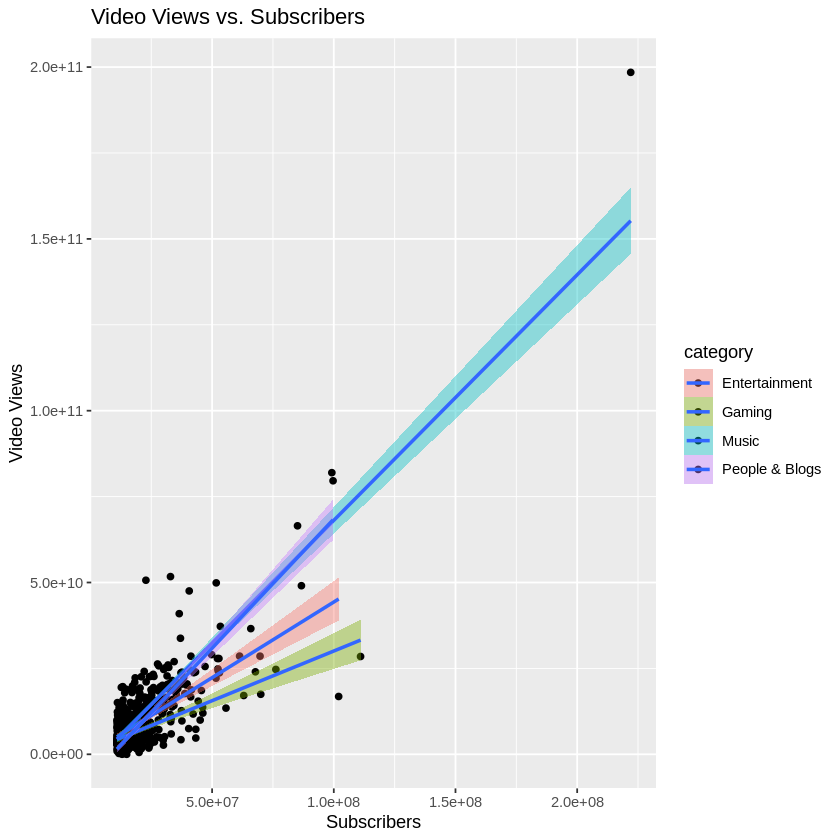

`geom_smooth()` using formula 'y ~ x'



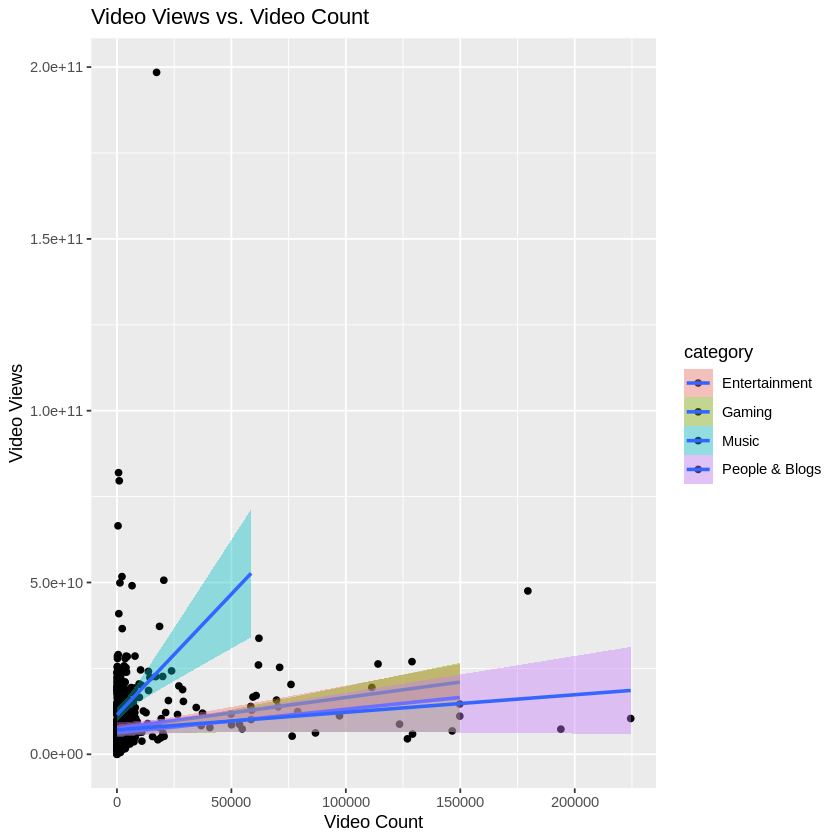

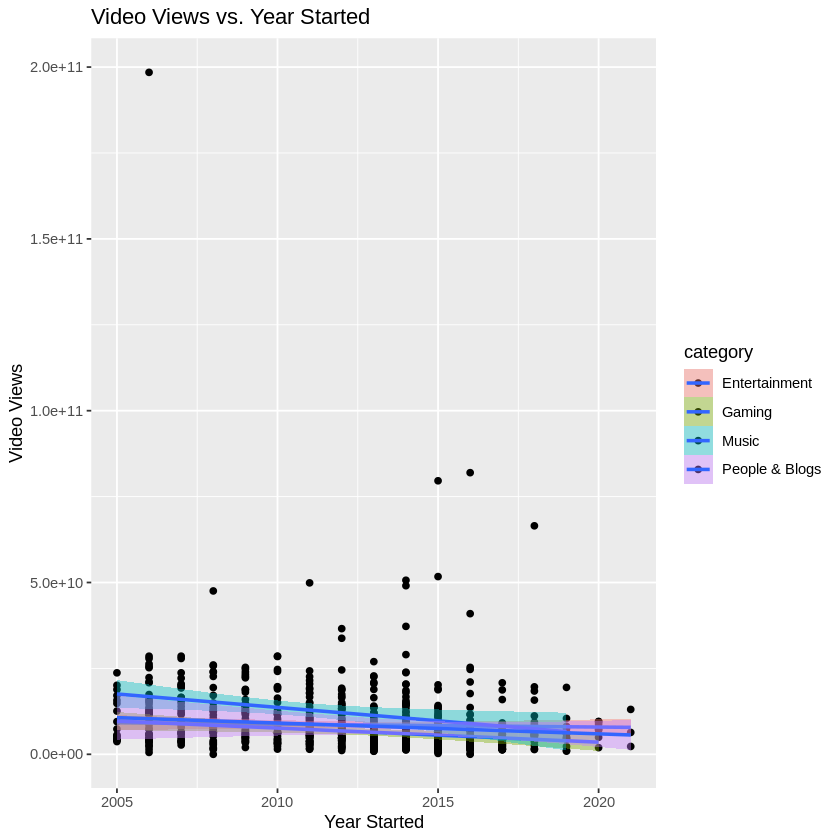

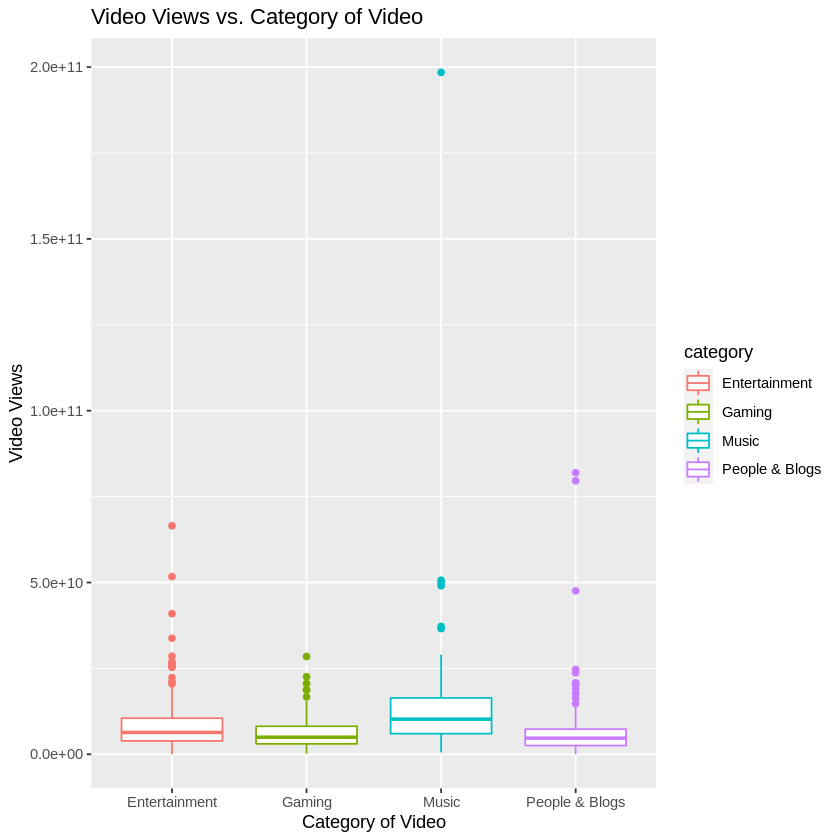

In [14]:
plot1<-ggplot(data, aes(x=subscribers, y=video.views, fill=category))+
    geom_point()+
    geom_smooth(method="lm")+
    labs(x="Subscribers", y="Video Views", title="Video Views vs. Subscribers")
plot1
plot2<-ggplot(data, aes(x=video.count, y=video.views, fill=category))+
    geom_point()+
    geom_smooth(method="lm")+
    labs(x="Video Count", y="Video Views", title="Video Views vs. Video Count")
plot2
plot3<-ggplot(data, aes(x=started, y=video.views, fill=category))+
    geom_point()+
    geom_smooth(method="lm")+
    labs(x="Year Started", y="Video Views", title="Video Views vs. Year Started")
plot3
plot4<-ggplot(data, aes(x=category, y=video.views, colour=category))+
    geom_boxplot()+
    labs(x="Category of Video", y="Video Views", title="Video Views vs. Category of Video")
plot4

<b> Analysis:<b>





We approached this problem by first trying to determine what variables to include in the model. Using the default exhaustive selection algorithm of library leaps regsubsets, the following were determined to be the best models for different number of variables (Figure 1).

In [15]:
#figure 1
model_selection<-regsubsets(video.views~subscribers+video.count+started+category, 
                            data=data, 
                            method="exhaustive")
summary_model<-summary(model_selection)
summary_model

Subset selection object
Call: regsubsets.formula(video.views ~ subscribers + video.count + 
    started + category, data = data, method = "exhaustive")
6 Variables  (and intercept)
                       Forced in Forced out
subscribers                FALSE      FALSE
video.count                FALSE      FALSE
started                    FALSE      FALSE
categoryGaming             FALSE      FALSE
categoryMusic              FALSE      FALSE
categoryPeople & Blogs     FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         subscribers video.count started categoryGaming categoryMusic
1  ( 1 ) "*"         " "         " "     " "            " "          
2  ( 1 ) "*"         " "         " "     " "            "*"          
3  ( 1 ) "*"         "*"         " "     " "            "*"          
4  ( 1 ) "*"         "*"         " "     "*"            "*"          
5  ( 1 ) "*"         "*"         "*"     "*"            "*"          
6  ( 1 ) "*"         "*"    

As you can see, above we temporarily omitted the interaction terms and restrict the focus to each variable’s contribution to the variation in video views. The motive was to increase the interpretability of the selection result from regsubsets. The key criteria we need to consider for each model is summarized in Figure 2.`

In [16]:
#Figure 2
data_summary_df <- tibble(
     n_input_variables = 1:6,
     RSQ = summary_model$rsq,
     RSS = summary_model$rss,
     ADJ.R2 = summary_model$adjr2,
     Cp = summary_model$cp)
data_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6624856,2.962173e+22,0.6619908,59.821914
2,0.6738198,2.862699e+22,0.6728619,36.977716
3,0.6884421,2.734367e+22,0.6870676,6.925989
4,0.6897532,2.722861e+22,0.6879255,6.052244
5,0.6906389,2.715087e+22,0.6883575,6.110719
6,0.6911456,2.710640e+22,0.6884084,7.000000


The full model (all variables) has the highest adjusted $R^2$ value and the lowest RSS value, suggesting that it explaines the variation in the response better than other candidates. The Mallows’ $C_p$ statstic of each model is plotted against $p$ in Figure 3:


integer(0)

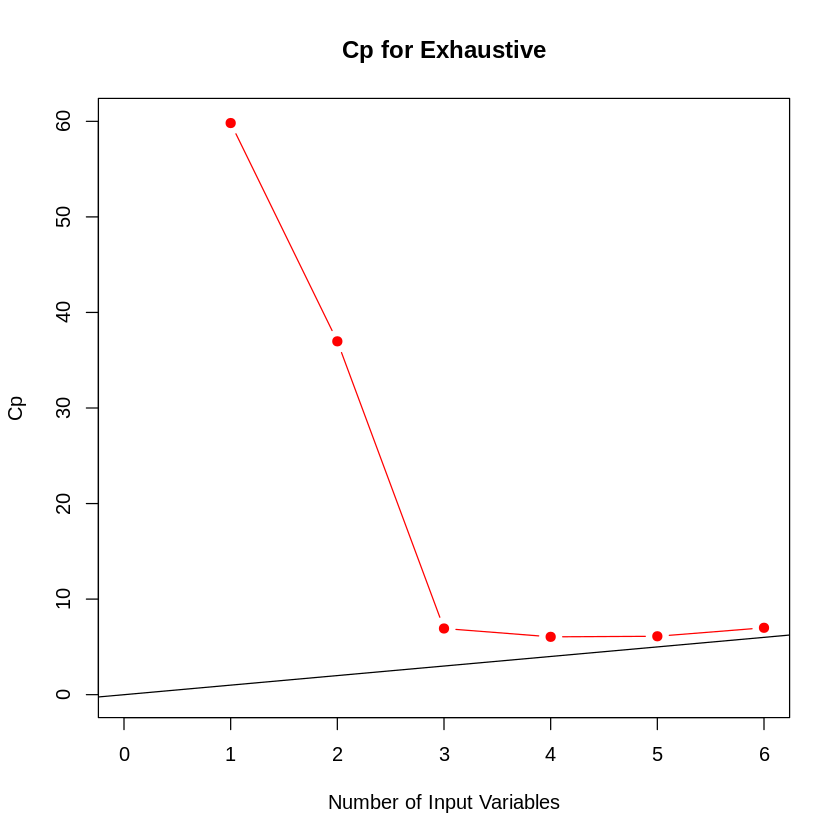

In [17]:
#Figure 3
plot(summary(model_selection)$cp,
  main = "Cp for Exhaustive",
  xlab = "Number of Input Variables", ylab = "Cp", type = "b", pch = 19,
  col = "red", 
    ylim=c(0, 60), 
    xlim=c(0, 6))+
abline(0, 1)

The reference line represents $C_p = p$. It’s shown that models 3,4,5,6 lies relatively near to the reference line, which means their $C_p$ values are close to the number of variables considered in that model. Model 4 has the lowest $C_p$ statistic, so one could argue that it is a preferable model. However, as shown in Figure 1, this model omits the dummy variable for category “People & Blog”. In essence, we are interested whether “category”  has a significant effect on the video views, and we encode this variable using 3 dummy variables. If we were to remove only one level of the “category” as model 4 suggests, the interpretation of the channel category would be incomplete. Since “category” appears to be significant, we should keep all 4 levels of this variable.

Up to this point, the best-performing model includes all 4 variables: subscribers, category, video count, year started. 


In [18]:
model<-lm(video.views~subscribers+video.count+category+started, data=data)
summary(model)



Call:
lm(formula = video.views ~ subscribers + video.count + category + 
    started, data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.227e+10 -2.427e+09 -2.902e+08  2.296e+09  6.194e+10 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.559e+11  1.434e+11   1.087 0.277439    
subscribers             6.142e+02  1.686e+01  36.433  < 2e-16 ***
video.count             5.741e+04  1.096e+04   5.238 2.17e-07 ***
categoryGaming         -1.518e+09  7.512e+08  -2.021 0.043676 *  
categoryMusic           2.293e+09  6.147e+08   3.731 0.000207 ***
categoryPeople & Blogs -7.684e+08  7.291e+08  -1.054 0.292302    
started                -7.927e+07  7.125e+07  -1.113 0.266312    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.328e+09 on 677 degrees of freedom
Multiple R-squared:  0.6911,	Adjusted R-squared:  0.6884 
F-statistic: 252.5 on 6 and 677 DF,  p-value: 

Among these predictor variables, the year started is the least significant (as seen in above lm model summary). To gain more insight into how much it contributes to explaining the response, we can calculate the partial correlation between video views and year started, controlling for other 3 variable.

In [19]:
pcmod1 <- lm(video.views ~ subscribers + category + video.count, data = data)
pcmod2 <- lm(started ~ subscribers + category + video.count, data = data)
pcor_started <- cor(resid(pcmod1), resid(pcmod2))
pcor_started
pcor_started^2


[1] -0.04271838

[1] 0.00182486

The partial correlation between the two (video views and year started) is -0.0427, and the sign of this value agrees with its coefficient in the model fitted. Notably, the square of partial correlation is only 0.0018. This indicates that the proportion of variation in the response explained by year started that’s unexplained by the other 3 variables is less than 0.2%. Since its P-value is also insignificant in the model, we can reasonably remove this variable from the model without losing the model’s explaining power. The new model fitted is therefore (refer to cell below):


In [20]:
model1<-lm(video.views~subscribers+video.count+category, data=data)
summary(model1)


Call:
lm(formula = video.views ~ subscribers + video.count + category, 
    data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.235e+10 -2.481e+09 -3.276e+08  2.372e+09  6.199e+10 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -3.663e+09  5.251e+08  -6.977 7.20e-12 ***
subscribers             6.157e+02  1.681e+01  36.636  < 2e-16 ***
video.count             5.898e+04  1.087e+04   5.426 8.02e-08 ***
categoryGaming         -1.528e+09  7.513e+08  -2.033   0.0424 *  
categoryMusic           2.435e+09  6.014e+08   4.050 5.73e-05 ***
categoryPeople & Blogs -9.556e+08  7.095e+08  -1.347   0.1785    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.329e+09 on 678 degrees of freedom
Multiple R-squared:  0.6906,	Adjusted R-squared:  0.6883 
F-statistic: 302.6 on 5 and 678 DF,  p-value: < 2.2e-16


Without surprise, the adjusted $R^2$ remains almost the same after removing the year started variable (the rest of analysis found below), and all variables in the new model appear significant. In the following discussions, this model is referred to as Model 1.

<b>Models with Interaction</b> <br>
To conitnue, we proceed by exploring how interaction terms can improve the performance of Model 1. There are three possible interaction terms - subscribers:category, subscribers:video.count, and category:video.count. We consider the model with all three interaction terms to be the full model (Model 2).

In [26]:
model2<-lm(video.views~subscribers*video.count+subscribers*category+video.count*category+category+subscribers+video.count, data=data)
summary(model2)


Call:
lm(formula = video.views ~ subscribers * video.count + subscribers * 
    category + video.count * category + category + subscribers + 
    video.count, data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.665e+10 -2.718e+09 -5.405e+08  2.183e+09  3.833e+10 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         4.348e+08  7.783e+08   0.559 0.576543    
subscribers                         3.851e+02  3.589e+01  10.729  < 2e-16 ***
video.count                        -3.509e+03  2.296e+04  -0.153 0.878584    
categoryGaming                      6.483e+08  1.313e+09   0.494 0.621745    
categoryMusic                      -3.091e+09  9.787e+08  -3.158 0.001659 ** 
categoryPeople & Blogs             -6.673e+09  1.192e+09  -5.597 3.19e-08 ***
subscribers:video.count             4.122e-03  8.957e-04   4.602 5.02e-06 ***
subscribers:categoryGaming         -1.099e+02  5.896e+01  -1.865

From the above summary, we see that the adjusted $R^2$ shows great improvement from past models, and all three interaction terms are significant. Model 2 is therefore better at capturing the variation in the response than Model 1.

integer(0)

ERROR: Error in qqnorm(res) + qqline(res, col = "steelblue", lwd = 2): non-numeric argument to binary operator


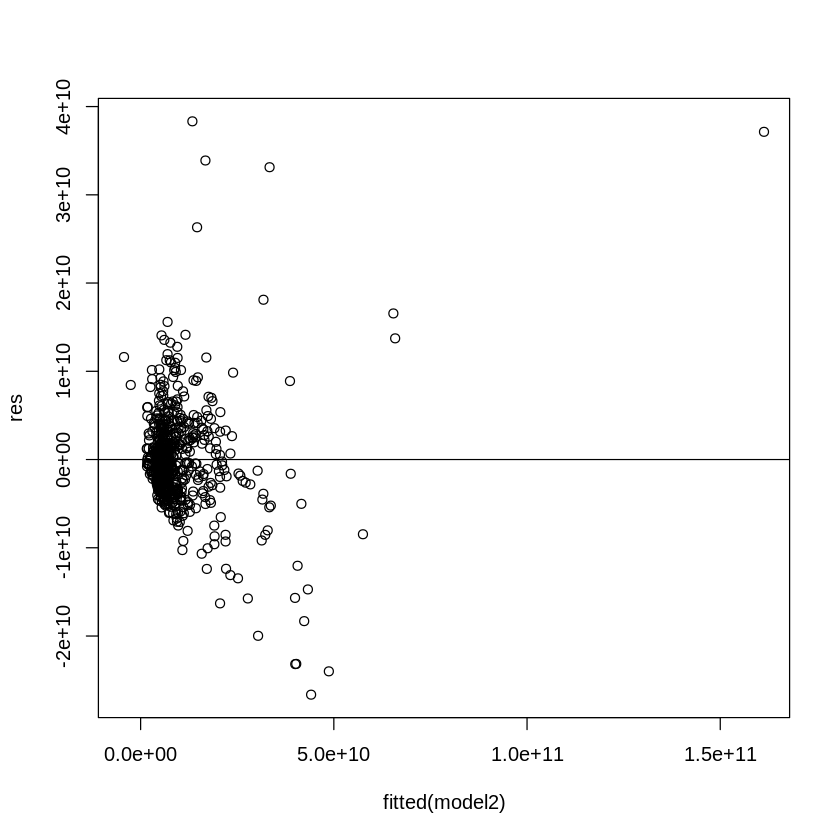

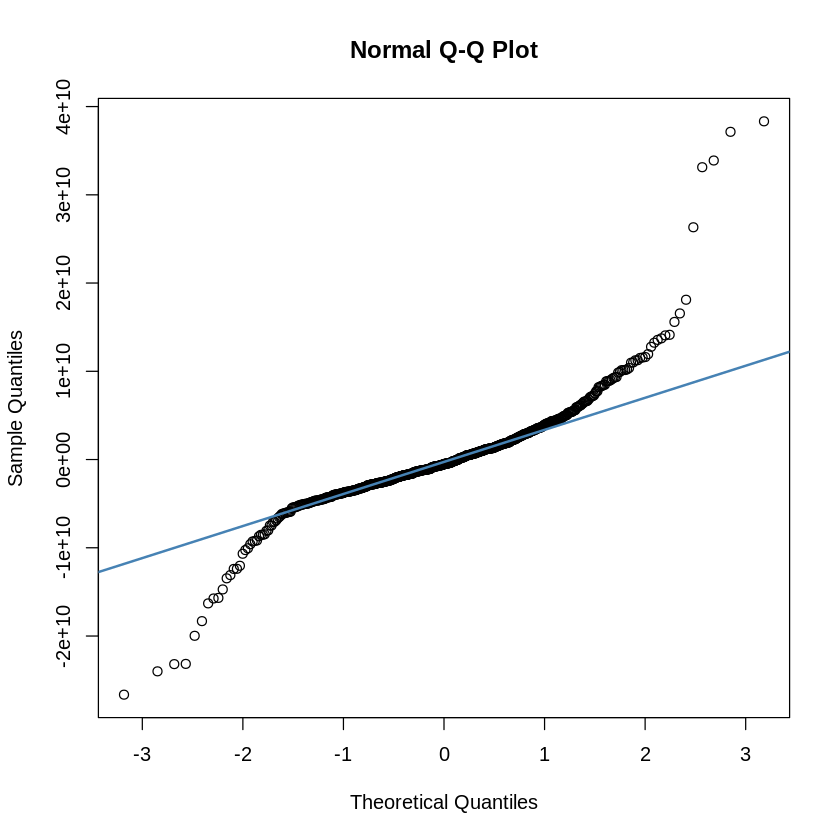

In [27]:
# Diagnostic Plots for model 2
res<-resid(model2)
resid_plot<-plot(fitted(model2), res)+
    abline(0,0)
resid_plot
qq_plot<-qqnorm(res)+
    qqline(res, col = "steelblue", lwd = 2)


NULL

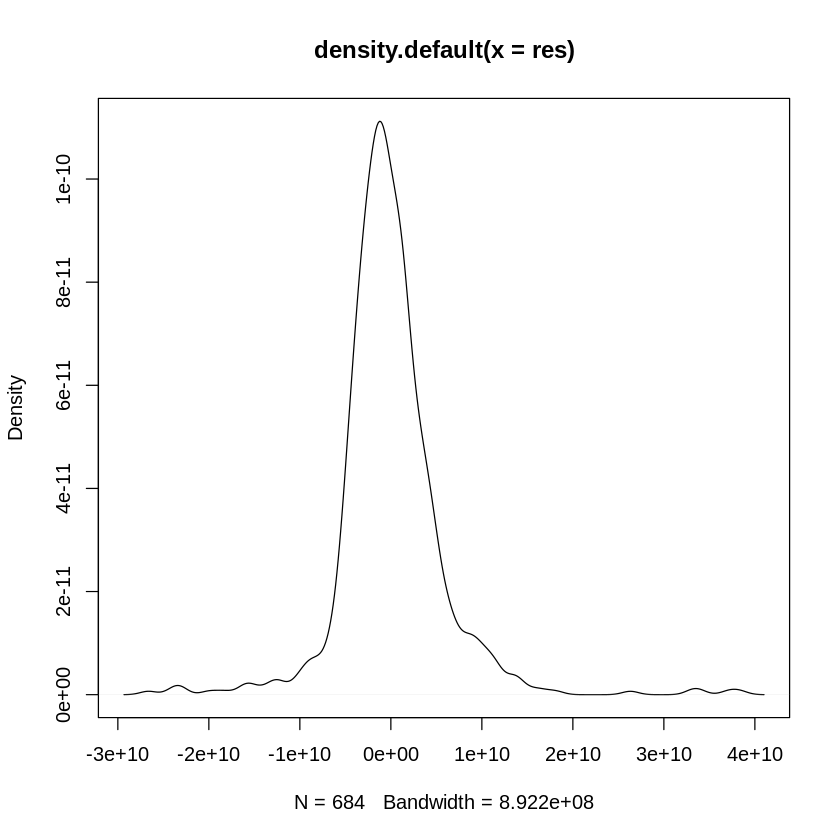

In [28]:
#Density plot for model 2(error distribution)
density_plot<-plot(density(res))
density_plot

The residual plot above suggests that this model has issues with non-constant variance. As the fitted value increases, the residuals fan out. This non-constant variance makes our model less reliable in predicting high number of views. 
<br>

To deal with the heteroscedasticity, we decide to refit the model with the same parameters but scaling the response values by $\tilde{y}=y^2$. The square root transformation compresses the higher values, and the lower values become more spread out. Therefore, we expect this transformation to normalize the skewed residual distribution and reduce the heteroscedasticity. The new model is shown below: 


In [24]:
sqrt_model<-lm(sqrt(video.views)~subscribers*video.count+subscribers*category+video.count*category+category+subscribers+video.count, data=data)
summary(sqrt_model)


Call:
lm(formula = sqrt(video.views) ~ subscribers * video.count + 
    subscribers * category + video.count * category + category + 
    subscribers + video.count, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-98094 -16622  -1549  14990 120709 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         4.780e+04  3.359e+03  14.231  < 2e-16 ***
subscribers                         1.761e-03  1.549e-04  11.367  < 2e-16 ***
video.count                         3.853e-01  9.910e-02   3.888 0.000111 ***
categoryGaming                     -1.595e+03  5.669e+03  -0.281 0.778451    
categoryMusic                       1.582e+04  4.224e+03   3.746 0.000195 ***
categoryPeople & Blogs             -1.970e+04  5.146e+03  -3.829 0.000141 ***
subscribers:video.count             1.786e-09  3.866e-09   0.462 0.644275    
subscribers:categoryGaming         -2.968e-04  2.545e-04  -1.166 0.243904    
subscribers:category

integer(0)

ERROR: Error in qqnorm(res1) + qqline(res1, col = "steelblue", lwd = 2): non-numeric argument to binary operator


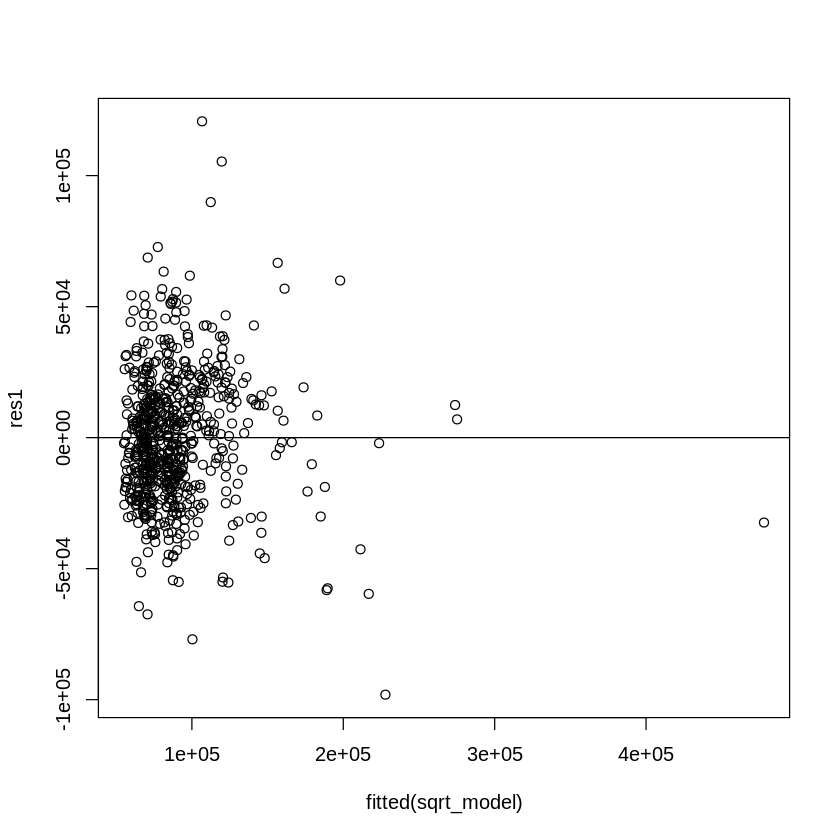

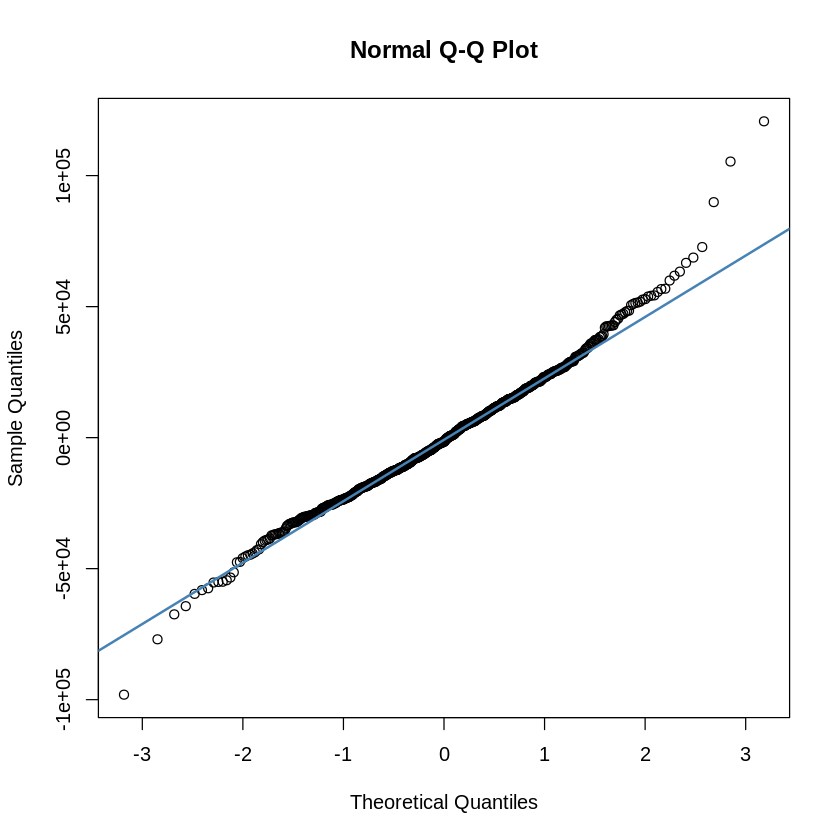

In [25]:
# Diagnostic Plots for sqrt_model
res1<-resid(sqrt_model)
resid_plot<-plot(fitted(sqrt_model), res1)+
    abline(0,0)
resid_plot
qq_plot<-qqnorm(res1)+
    qqline(res1, col = "steelblue", lwd = 2)

From the residual plot and the normal QQ plot, we see that the problems of non-constant variance and heavy-tail residual distribution are greatly improved. The residuals appear to be more evenly distributed around zero at all fitted values, and the distribution of standardized residuals is closer to the theoretical quantiles of standard normal. However, this improvement is at the expense of a decrease in adjusted $R^2$. Though one could argue that Model 2 potentially violates the non-constant variance assumption in linear regression, it’s noteworthy that the funnel shape in Model 2 residual plot is pronounced only when fitted values become extremely large. For a channel to get the number of views at that scale (e.g. $> 20$ billion), external factors such as seasonality, personalization targeting the audience market, and topic interest can play much more important roles than the variables included in our model. That explains why these points do not adhere to the model well. In the range of video views where the majority of the observations fall into, the residuals exhibit a much more random distribution around zero. It would be inappropriate to adopt the transformation just to balance the residuals of a few points at the expense of having $10\%$ of the variation in the response unexplained. 


<b> Conclusion</b> <br>

In this project, we explored how different attributes of a Youtube channel may affect its total number of video views. We began by visualizing the relationship between the response variable and each predictor, followed by inspecting individual contributions from each variable to explain the variation in the response. We resorted to different diagnostic statistics such as Mallow’s $C_p$, adjusted $R^2$, and partial correlation to determine the number of variables to include in the model. We subsequently investigated how interaction terms between the chosen variables from the last step may improve the fit of the model and examined potential violations of the linear regression assumptions through residual plots and normal Q-Q plots. In addition, we attempted the square root transformation to reduce the heteroscedasticity but decided to fall back to the linear model for a better description of the data.

The best model was collected by comparing the CP of all possible models without interaction. Then, comparing this model with models with interaction between input variables. In the end, collecting the most fittable one. We concluded that the relationship between the number of video views as response variable and our explanatory variables is in linear regression. Our model is: video views = 4.348*10^8 -3.509*10^3 *video count +6.483*10^8*categoryGaming - 3.091*10^9*categoryMusic - 6.673*10^9*categoryPeople&Blogs + 3.852*10^2*subscribers + 4.902*10^3*video count * categoryGaming + 1.259*10^5*video count*categoryMusic - 7.659*10^4*video count*categoryPeople&Blogs+4.122*10^-3*video count * subscribers - 1.099*10^2*categoryGaming*subscribers+2.726*10^2*categoryMusic*subscribers + 3.348*10^2*categoryPeople&Blogs*subscribers. (categoryGaming means when the category is Gaming, the categoryGaming = 1, otherwise it equals 0. Other kinds of categories are also in this way). The relation was shown in Figure 2 (model 2).
It shows that the most influential input variable on the number of video views is categoryPeople&Blogs. If the category is about People & Blogs, the expected number of video views will decrease by 667.3 billion. <br>

One major limitation of the model arises from the choice of channels in the dataset. The observations are collected only for top-ranking channels with the highest number of subscribers, instead of randomly sampling channels on Youtube. Since we only had limited information about the behavior of less subscribed channels, the model may be unexpectedly inaccurate in describing the performance of channels outside the range of our dataset. In fact, 96.6% (https://www.thehoth.com/blog/youtube-stats/) of Youtube channels have fewer than 10,000 subscribers, while our model completely missed out on this majority. In this project, we didn’t have access to other related statistics. Hence we cannot draw any conclusions on whether our model may or may not be a reasonable representation of the Youtube channels with their numbers of subscribers on the lower end. To complement our study, it would be beneficial to conduct separate research on randomly sampled channels or shift the focus to another subpopulation of channels with a different range of subscribers. 


For future relative research, it might be useful in finding how to increase video views. For example, if someone wishes to increase the video views of his video, they can change the channel category to gaming. That might be useful for video bloggers. On the other hand, for Youtube, they can know what people like to watch and then research and develop more user-friendly services.

<b> References </b> 

Bärtl, M. (2018). YouTube channels, uploads and views: A statistical analysis of the past 10            years. Convergence, 24(1), 16–32. https://doi.org/10.1177/1354856517736979

Jha, S. (2022, August 14). Most subscribed YouTube channels. Kaggle. Retrieved December 6, 2022, from https://www.kaggle.com/datasets/surajjha101/top-youtube-channels-data 